In [1]:
import pandas as pd
import rushd as rd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

In [5]:
base_datadir = rd.datadir/ '2024.10.17_EdU_timecourse'
data_path = base_datadir / 'single_cell_csvs'
yaml_file =  base_datadir / 'metadata.yaml'
figpath = '../figures/fig3/'

In [6]:
cache_file = base_datadir / 'df_cache.gzip'

load_previous = True 
if (cache_file.exists() & load_previous ):
    data = pd.read_parquet(cache_file)
    print("Loading cached data")
else:
    data = rd.flow.load_csv_with_metadata(data_path=data_path, yaml_path=yaml_file)
    data.to_parquet(rd.outfile(cache_file))
    print("Loading new data and storing cache")

Loading cached data


<AxesSubplot:xlabel='GFP-H', ylabel='Density'>

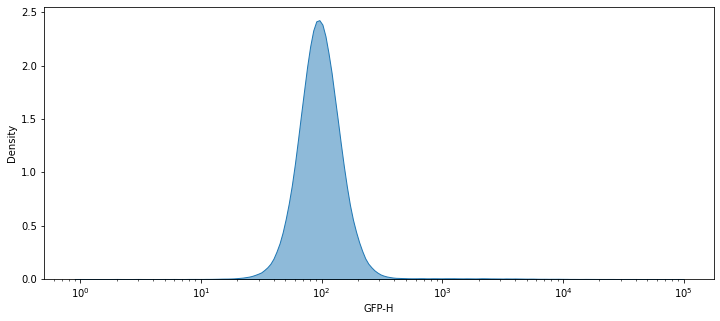

In [14]:
NIL_data_nonzero = data[ (data.condition == "NIL") &
                  (data.aphidicolin == "none") &
                  (data.timepoint == "14dpi") &
                  (data["GFP-H"] > 0)]


fig0, axs0 = plt.subplots(1,1, figsize = (12, 5), facecolor="w")

sns.kdeplot(data = NIL_data_nonzero, x = "GFP-H", log_scale=True, fill = True, alpha = 0.5, ax = axs0)


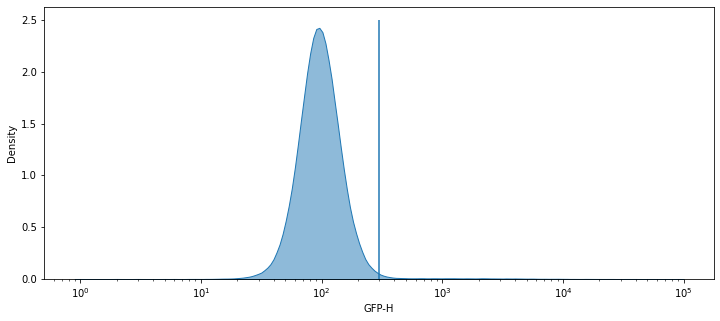

In [15]:
GFP_positive_gate_lenient = 300
axs0.vlines(x = GFP_positive_gate_lenient, ymin = 0, ymax = 2.5)
fig0

<AxesSubplot:xlabel='GFP-H', ylabel='Density'>

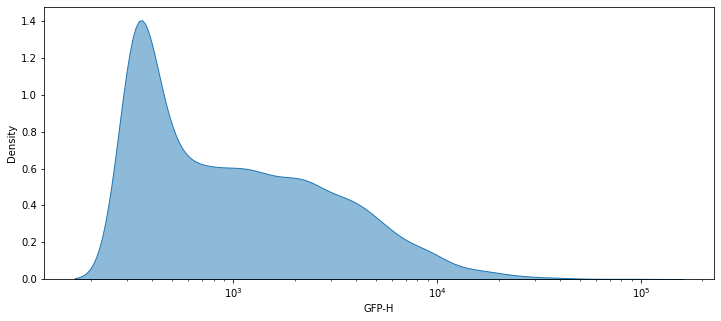

In [16]:
NIL_data_gfp_pos = data[  (data.condition == "NIL") &
                  (data.aphidicolin == "none") &
                  (data.timepoint == "14dpi")  &
                  (data["GFP-H"] > GFP_positive_gate_lenient)]

fig1, axs1 = plt.subplots(1,1, figsize = (12, 5), facecolor="w")

sns.kdeplot(data = NIL_data_gfp_pos, x = "GFP-H", log_scale=True, fill = True, alpha = 0.5, ax =axs1)

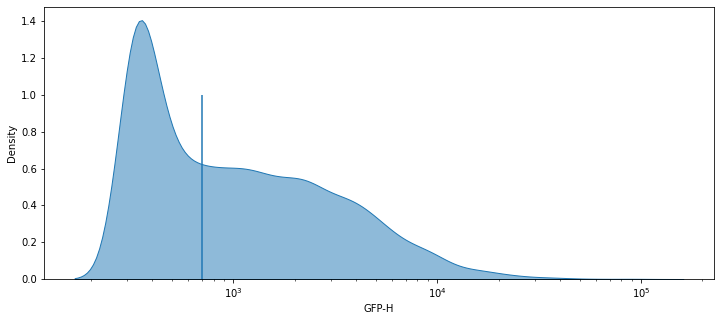

In [17]:
GFP_positive_gate_strict = 700
axs1.vlines(x = GFP_positive_gate_strict, ymin = 0, ymax = 1)
fig1

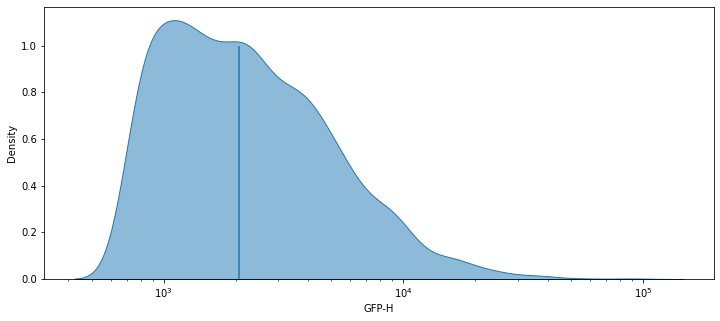

In [18]:
NIL_data_gfp_pos_strict = data[  (data.condition == "NIL") &
                  (data.aphidicolin == "none") &
                  (data.timepoint == "14dpi") &
                  (data["GFP-H"] > GFP_positive_gate_strict)]

fig2, axs2 = plt.subplots(1,1, figsize = (12, 5), facecolor="w")

sns.kdeplot(data = NIL_data_gfp_pos_strict, x = "GFP-H", log_scale=True, fill = True, alpha = 0.5, ax =axs2)

GFP_bright_gate = np.percentile(NIL_data_gfp_pos_strict["GFP-H"], 50)
axs2.vlines(x = GFP_bright_gate, ymin = 0, ymax = 1)

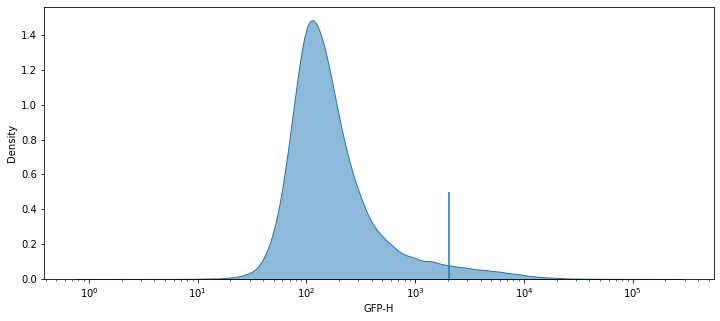

In [19]:
NIL_RIDD_data_nonzero = data[ (data.condition == "NILRIDD") &
                  (data.aphidicolin == "none") &
                  (data.timepoint == "14dpi") &
                  (data["GFP-H"] > 0)].sample(100000)

fig3, axs3 = plt.subplots(1,1, figsize = (12, 5), facecolor="w")

sns.kdeplot(data = NIL_RIDD_data_nonzero, x = "GFP-H", log_scale=True, fill = True, alpha = 0.5, ax =axs3)

axs3.vlines(x = GFP_bright_gate, ymin = 0, ymax = 0.5)

# Find EdU threshold

In [20]:
#Forgot to change on the attune the label for RL1
data = data.rename(columns={"Cy5-EU-A":"Cy5-EdU-A", "Cy5-EU-H":"Cy5-EdU-H", "Cy5-EU-W":"Cy5-EdU-W"})

<AxesSubplot:xlabel='Cy5-EdU-A', ylabel='Density'>

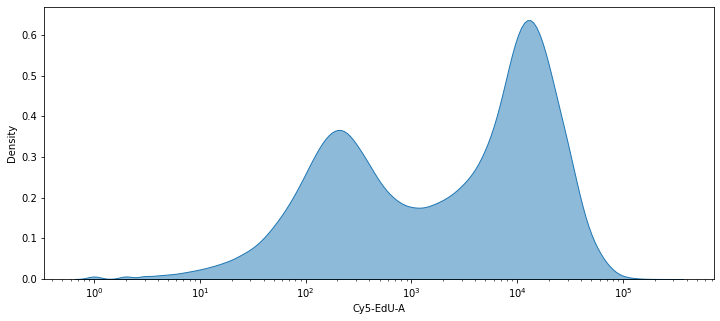

In [21]:
#Plot a highly proliferative condition to determine initial EdU positive gate
NIL_RIDD_data_nonzero = data[ (data.condition == "NILRIDD") &
                  (data.aphidicolin == "none") &
                  (data.timepoint == "4dpi") &
                  (data["Cy5-EdU-A"] > 0)]

fig4, axs4 = plt.subplots(1,1, figsize = (12, 5), facecolor="w")

sns.kdeplot(data = NIL_RIDD_data_nonzero, x = "Cy5-EdU-A", log_scale=True, fill = True, alpha = 0.5, ax =axs4)

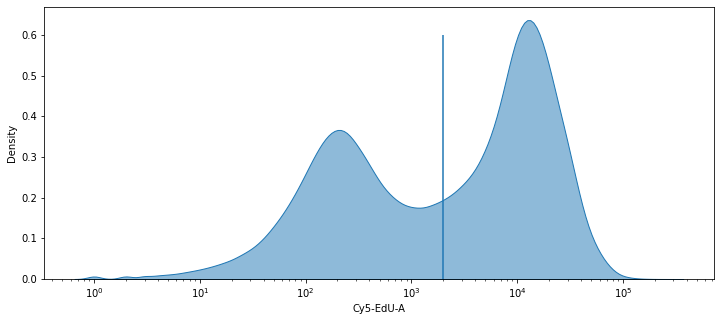

In [22]:
EdU_positive_gate = 2000
axs4.vlines(x = EdU_positive_gate, ymin = 0, ymax = 0.6)
fig4

Look at joint distribution of aphidicolin-treated cells to determine "background" EdU incorporation

[(3, 1000000), (10, 300000)]

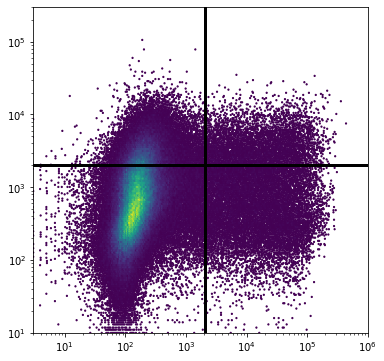

In [23]:
fig6, axs6 = plt.subplots(1, 1, figsize = (6, 6))

subdata = data[(data.condition == "NILRIDD") &
                  (data.aphidicolin == "aph") &
                  (data.timepoint == "4dpi") &
                  (data["Cy5-EdU-A"] > 0)&
                  (data["GFP-H"] > 0)]

plt.hexbin(x = subdata['GFP-H'], y = subdata['Cy5-EdU-A'], xscale = 'log', yscale = 'log', gridsize=300, mincnt=1)

axs6.hlines(y = EdU_positive_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
axs6.vlines(x = GFP_bright_gate, ymin = 1, ymax = 10**6 , color = 'black', lw = 3)
axs6.set(xlim=(3, 10**6), ylim=(10, 3*10**5))

Some cells are above the original EdU threshold. Likely due to either DNA damage repair or incomplete blockage of DNA polymerases by the low-ish does of aphidicolin. 1 uM aphidicolin was used due to prolonged treatment. 10 uM appears to be a common dose for acute treatments when doing EdU pulsing. 1 uM was used in Babos and Galloway for overnight treatments.

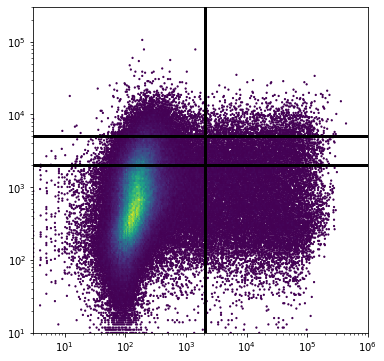

In [24]:
EdU_strict_gate = 5*10**3
axs6.hlines(y = EdU_strict_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
fig6

Adding a stricter gate for EdU incorporation above the levels observed in aphidicolin-treated cells.

Examine gates now on our original, highly-proiferative population

[(3, 1000000), (10, 300000)]

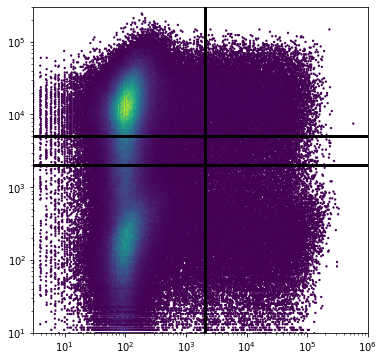

In [25]:
fig5, axs5 = plt.subplots(1, 1, figsize = (6, 6))

subdata = data[(data.condition == "NILRIDD") &
                  (data.aphidicolin == "none") &
                  (data.timepoint == "4dpi") &
                  (data["Cy5-EdU-A"] > 0)&
                  (data["GFP-H"] > 0)]

plt.hexbin(x = subdata['GFP-H'], y = subdata['Cy5-EdU-A'], xscale = 'log', yscale = 'log', gridsize=300, mincnt=1)

axs5.hlines(y = EdU_positive_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
axs5.hlines(y = EdU_strict_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
axs5.vlines(x = GFP_bright_gate, ymin = 1, ymax = 10**6 , color = 'black', lw = 3)
axs5.set(xlim=(3, 10**6), ylim=(10, 3*10**5))

Examine gates on post-sorted population of cells

[(3, 1000000), (10, 300000)]

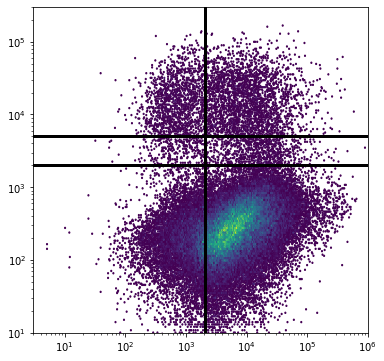

In [26]:
fig5, axs5 = plt.subplots(1, 1, figsize = (6, 6))

subdata = data[(data.condition == "NILRIDD") &
                  (data.aphidicolin == "none") &
                  (data.timepoint == "7dps") &
                  (data["Cy5-EdU-A"] > 0)&
                  (data["GFP-H"] > 0)]

plt.hexbin(x = subdata['GFP-H'], y = subdata['Cy5-EdU-A'], xscale = 'log', yscale = 'log', gridsize=300, mincnt=1)

axs5.hlines(y = EdU_positive_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
axs5.hlines(y = EdU_strict_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
axs5.vlines(x = GFP_bright_gate, ymin = 1, ymax = 10**6 , color = 'black', lw = 3)
axs5.set(xlim=(3, 10**6), ylim=(10, 3*10**5))

[(3, 1000000), (10, 300000)]

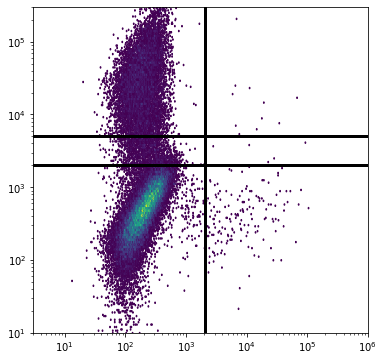

In [27]:
fig5, axs5 = plt.subplots(1, 1, figsize = (6, 6))

subdata = data[(data.condition == "RIDD") &
                  (data.aphidicolin == "none") &
                  (data.timepoint == "7dps") &
                  (data["Cy5-EdU-A"] > 0)&
                  (data["GFP-H"] > 0)]

plt.hexbin(x = subdata['GFP-H'], y = subdata['Cy5-EdU-A'], xscale = 'log', yscale = 'log', gridsize=300, mincnt=1)

axs5.hlines(y = EdU_positive_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
axs5.hlines(y = EdU_strict_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
axs5.vlines(x = GFP_bright_gate, ymin = 1, ymax = 10**6 , color = 'black', lw = 3)
axs5.set(xlim=(3, 10**6), ylim=(10, 3*10**5))

[(3, 1000000), (10, 300000)]

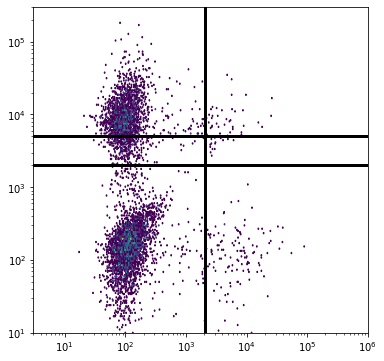

In [28]:
fig5, axs5 = plt.subplots(1, 1, figsize = (6, 6))

subdata = data[(data.condition == "NIL") &
                  (data.aphidicolin == "none") &
                  (data.timepoint == "14dpi") &
                  (data.well =='B1') &
                  (data["Cy5-EdU-A"] > 0)&
                  (data["GFP-H"] > 0)]

plt.hexbin(x = subdata['GFP-H'], y = subdata['Cy5-EdU-A'], xscale = 'log', yscale = 'log', gridsize=300, mincnt=1)

axs5.hlines(y = EdU_positive_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
axs5.hlines(y = EdU_strict_gate, xmin = 1, xmax = 10**6 , color = 'black', lw = 3)
axs5.vlines(x = GFP_bright_gate, ymin = 1, ymax = 10**6 , color = 'black', lw = 3)
axs5.set(xlim=(3, 10**6), ylim=(10, 3*10**5))

In [29]:
data['GFP_status'] = np.where(data['GFP-H']>GFP_bright_gate, "GFP_positive", "GFP_negative")

In [30]:
# groupby wells, calculate the number of iMNs and total cells in each well, then calculate perceny purity and percent yield

groupby_cols = ['condition', 'aphidicolin', 'timepoint', 'BioRep', 'well', 'GFP_status']


EdU_count = data[(data['Cy5-EdU-A'] > EdU_strict_gate)].groupby(groupby_cols).size().reset_index(name = "EdU_count")
sc_count = data.groupby(groupby_cols).size().reset_index(name = "gfp_gated_cell_count")

summary_df_GFP = EdU_count.merge(sc_count)
summary_df_GFP["fraction_EdU_positive"] = summary_df_GFP["EdU_count"] / summary_df_GFP["gfp_gated_cell_count"] * 100

summary_df_GFP

,condition,aphidicolin,timepoint,BioRep,well,GFP_status,EdU_count,gfp_gated_cell_count,fraction_EdU_positive
0,NIL,none,14dpi,1,B1,GFP_negative,1640,5252,31.226200
1,NIL,none,14dpi,1,B1,GFP_positive,42,199,21.105528
2,NIL,none,14dpi,2,B2,GFP_negative,86136,187624,45.908839
3,NIL,none,14dpi,2,B2,GFP_positive,54,177,30.508475
4,NIL,none,14dpi,3,B3,GFP_negative,87329,202805,43.060575
...,...,...,...,...,...,...,...,...,...
79,RIDD,none,7dps,1,C4,GFP_negative,3024,13538,22.337125
80,RIDD,none,7dps,2,C5,GFP_negative,2769,10383,26.668593
81,RIDD,none,7dps,2,C5,GFP_positive,2,17,11.764706
82,RIDD,none,7dps,3,C6,GFP_negative,4042,23216,17.410407


In [31]:
groupby_cols = ['condition', 'aphidicolin', 'timepoint', 'BioRep', 'well']
summary_df_GFP['well_cell_count'] = summary_df_GFP.groupby(groupby_cols)['gfp_gated_cell_count'].transform('sum')
summary_df_GFP['well_EdU_count'] = summary_df_GFP.groupby(groupby_cols)['EdU_count'].transform('sum')
summary_df_GFP['well_EdU_frac'] = summary_df_GFP['well_EdU_count'] / summary_df_GFP['well_cell_count']
summary_df_GFP

,condition,aphidicolin,timepoint,BioRep,well,GFP_status,EdU_count,gfp_gated_cell_count,fraction_EdU_positive,well_cell_count,well_EdU_count,well_EdU_frac
0,NIL,none,14dpi,1,B1,GFP_negative,1640,5252,31.226200,5451,1682,0.308567
1,NIL,none,14dpi,1,B1,GFP_positive,42,199,21.105528,5451,1682,0.308567
2,NIL,none,14dpi,2,B2,GFP_negative,86136,187624,45.908839,187801,86190,0.458943
3,NIL,none,14dpi,2,B2,GFP_positive,54,177,30.508475,187801,86190,0.458943
4,NIL,none,14dpi,3,B3,GFP_negative,87329,202805,43.060575,203622,87576,0.430091
...,...,...,...,...,...,...,...,...,...,...,...,...
79,RIDD,none,7dps,1,C4,GFP_negative,3024,13538,22.337125,13538,3024,0.223371
80,RIDD,none,7dps,2,C5,GFP_negative,2769,10383,26.668593,10400,2771,0.266442
81,RIDD,none,7dps,2,C5,GFP_positive,2,17,11.764706,10400,2771,0.266442
82,RIDD,none,7dps,3,C6,GFP_negative,4042,23216,17.410407,23378,4051,0.173283


In [32]:
cond_map = {'NIL-none':'NIL',
            'NILRIDD-none':'NILRIDD',
            'NILRIDD-aph': 'NILRIDD+aph',
            'RIDD-none':'RIDD',
            'RIDD-aph': 'RIDD+aph',
            }

In [33]:
summary_df_GFP['cond_plus_treatment'] = summary_df_GFP['condition'] + '-' + summary_df_GFP['aphidicolin']
summary_df_GFP['cond_plus_treatment']=summary_df_GFP['cond_plus_treatment'].map(cond_map)

In [34]:
summary_df_GFP

,condition,aphidicolin,timepoint,BioRep,well,GFP_status,EdU_count,gfp_gated_cell_count,fraction_EdU_positive,well_cell_count,well_EdU_count,well_EdU_frac,cond_plus_treatment
0,NIL,none,14dpi,1,B1,GFP_negative,1640,5252,31.226200,5451,1682,0.308567,NIL
1,NIL,none,14dpi,1,B1,GFP_positive,42,199,21.105528,5451,1682,0.308567,NIL
2,NIL,none,14dpi,2,B2,GFP_negative,86136,187624,45.908839,187801,86190,0.458943,NIL
3,NIL,none,14dpi,2,B2,GFP_positive,54,177,30.508475,187801,86190,0.458943,NIL
4,NIL,none,14dpi,3,B3,GFP_negative,87329,202805,43.060575,203622,87576,0.430091,NIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,RIDD,none,7dps,1,C4,GFP_negative,3024,13538,22.337125,13538,3024,0.223371,RIDD
80,RIDD,none,7dps,2,C5,GFP_negative,2769,10383,26.668593,10400,2771,0.266442,RIDD
81,RIDD,none,7dps,2,C5,GFP_positive,2,17,11.764706,10400,2771,0.266442,RIDD
82,RIDD,none,7dps,3,C6,GFP_negative,4042,23216,17.410407,23378,4051,0.173283,RIDD


In [76]:
summary_df_GFP['cond_treat_GFP']= summary_df_GFP['cond_plus_treatment'] + '-'+ summary_df_GFP['GFP_status']

In [77]:
gfp_mapping =  {'NIL-GFP_negative':'NIL-GFP negative',
            'NILRIDD-GFP_negative':'NILRIDD-GFP negative',
            'NILRIDD+aph-GFP_negative':'NILRIDD+aph-GFP negative',
            'RIDD-GFP_negative':'RIDD',
            'RIDD+aph-GFP_negative':'RIDD+aph',
            'NIL-GFP_positive':'NIL-GFP positive',
            'NILRIDD-GFP_positive':'NILRIDD-GFP positive',
            'NILRIDD+aph-GFP_positive':'NILRIDD+aph-GFP positive',
            'RIDD-GFP_positive':'RIDD-GFP positive',
            'RIDD+aph-GFP_positive':'RIDD+aph-GFP positive',
            }

In [78]:
summary_df_GFP['cond_treat_GFP'] = summary_df_GFP['cond_treat_GFP'].map(gfp_mapping)

In [57]:
summary_df_GFP

,condition,aphidicolin,timepoint,BioRep,well,GFP_status,EdU_count,gfp_gated_cell_count,fraction_EdU_positive,well_cell_count,well_EdU_count,well_EdU_frac,cond_plus_treatment,cond_treat_GFP
0,NIL,none,14dpi,1,B1,GFP_negative,1640,5252,31.226200,5451,1682,0.308567,NIL,NIL-GFP negative
1,NIL,none,14dpi,1,B1,GFP_positive,42,199,21.105528,5451,1682,0.308567,NIL,NIL-GFP positive
2,NIL,none,14dpi,2,B2,GFP_negative,86136,187624,45.908839,187801,86190,0.458943,NIL,NIL-GFP negative
3,NIL,none,14dpi,2,B2,GFP_positive,54,177,30.508475,187801,86190,0.458943,NIL,NIL-GFP positive
4,NIL,none,14dpi,3,B3,GFP_negative,87329,202805,43.060575,203622,87576,0.430091,NIL,NIL-GFP negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,RIDD,none,7dps,1,C4,GFP_negative,3024,13538,22.337125,13538,3024,0.223371,RIDD,RIDD
80,RIDD,none,7dps,2,C5,GFP_negative,2769,10383,26.668593,10400,2771,0.266442,RIDD,RIDD
81,RIDD,none,7dps,2,C5,GFP_positive,2,17,11.764706,10400,2771,0.266442,RIDD,RIDD-GFP positive
82,RIDD,none,7dps,3,C6,GFP_negative,4042,23216,17.410407,23378,4051,0.173283,RIDD,RIDD


# Final plots

In [36]:
subdata = summary_df_GFP[(summary_df_GFP['timepoint'] == '7dps') & 
                     (summary_df_GFP['gfp_gated_cell_count'] > 1000)]

temp = [
    subdata[(subdata.condition == 'NILRIDD') & (subdata.GFP_status == 'GFP_positive')],
    subdata[(subdata.condition == 'RIDD') & (subdata.GFP_status == 'GFP_negative')],
    ]

subdata = pd.concat(temp)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RIDD_aph vs. NILRIDD_none: t-test independent samples, P_val:5.693e-01 t=6.192e-01
RIDD_none vs. NILRIDD_none: t-test independent samples, P_val:3.242e-03 t=6.301e+00


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


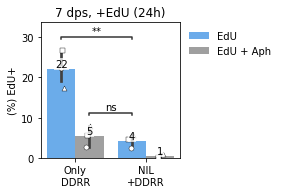

In [37]:
# Plotting params
x = 'condition'
y = 'fraction_EdU_positive'
hue = 'aphidicolin'
hue_order = ['none', 'aph']
order = ['RIDD', 'NILRIDD']


palette = {'none':'dodgerblue',
           'aph':'grey'}


marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

# Plot as box
sns.barplot(ax=ax,
    data=subdata,
    x=x, y=y, hue=hue,
    order=order, hue_order=hue_order,
    palette=palette, alpha=0.75)


for (i, BioRep) in enumerate(subdata.BioRep.unique()):
    sns.stripplot(
        ax=ax, data=subdata[subdata.BioRep == BioRep],
        x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={hue:'white' for hue in hue_order}, size=5,
        edgecolor='black', linewidth=0.4)
    
# Add in stats
# Pairs for stats comp
pairs = [
    (('RIDD', 'none'), ('NILRIDD', 'none')),
    (('RIDD', 'aph'), ('NILRIDD', 'none'))
]
annot = Annotator(ax=ax,
    data=subdata, pairs=pairs,
    x=x, y=y, hue=hue,
    order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)
    
# Adjust labels
lmap = {'aph':'EdU + Aph', 'none':'EdU'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format
ax.set_ylabel('(%) EdU+')
ax.set_xlabel('')
label_dict = {'NILRIDD':'NIL\n+DDRR', 'RIDD': 'Only\nDDRR'}
ax.set_xticklabels([label_dict[l] for l in order])
plt.title('7 dps, +EdU (24h)')

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=0)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# plt.savefig(figpath + 'EdU-7dps.svg', bbox_inches='tight')
    